The term **derivative** refers to a type of **financial contract** whose value is dependent on an underlying asset (stocks, bonds, commodities, currencies, interest rates, and market indexes) or group of assets. Prices for derivatives derive from fluctuations in the underlying asset. Derivatives can be used to either mitigate risk (hedging) or assume risk with the expectation of commensurate reward (speculation). 

**Key points**:
- Derivatives are financial contracts, set between two or more parties, that derive their value from an underlying asset, group of assets, or benchmark.
- A derivative can trade on an exchange or over-the-counter.
- Prices for derivatives derive from fluctuations in the underlying asset.
- Derivatives are usually leveraged instruments, which increases their potential risks and rewards.
- Common derivatives include futures contracts, forwards, options, and swaps.

Depending on the type of derivative, its fair value or price will be calculated in a different manner.

### Problem definiton
In this case study, the predicted variable (y) is the price of the option and the variables selected to estimate the market price are stock price, strike price, time to expiration, volatility, interest rate, and dividend yield. The predicted variable was generated using random inputs and feeding them into the **Black-Scholes model**, defined for a call option as :

**$Se^{-q\tau}\phi(d_{1})-e^{-r\tau}\phi(d_{2})$**

with 

$ d_{1} = \frac{ln(\frac{S}{K})+(r - q + \frac{\sigma^{2}}{2})\tau}{\sigma\sqrt{\tau}}$

and

$ d_{2} = \frac{ln(\frac{S}{K})+(r - q - \frac{\sigma^{2}}{2})\tau}{\sigma\sqrt{\tau}} = d_{1}-\sigma\sqrt{\tau}$

where 
- S is the stock price
- K is the strike price
- r is the risk-free rate
- q is the annual dividend yield
- $\tau = T-t$ is the time to maturity
- $\sigma$ is the volatility

We can define the **moneyness** $M = \frac{K}{S}$, that is the relative position of the current price (or future price) of an underlying asset with respect to the strike price of a derivative. So we can rewrite the B-S model as (having $q=0$):

$e^{-q\tau}\phi(\frac{-ln(M)+(r+\frac{\sigma^{2}}{2})\tau}{\sigma\sqrt{\tau}}) -e^{-r\tau}M\phi(\frac{-ln(M)+(r-\frac{\sigma^{2}}{2})\tau}{\sigma\sqrt{\tau}})$

So the parameters that feed into the Black-Scholes option pricing model are moneyness, risk-free rate, volatility, and time to maturity. The parameter that plays the central role in derivative market is volatility, as it is directly related to the movement of the stock prices. The **volatility** depends on the option moneyness and time to maturity, so we can model it as:

$\sigma(M,\tau) = \sigma_{0} + \alpha\tau + \beta(M-1)^{2}$

### Data generation
In order to generate the dataset we need to simulate some parameters and compute the predicted variable.

In [11]:
import numpy as np
import pandas as pd
from scipy.stats import norm

alpha = 0.1
beta = 0.1
sigma_zero = 0.2
risk_free_rate = 0.05

def option_volatility(moneyness, time_to_maturity): 
    return sigma_zero + alpha * time_to_maturity + beta * np.square(moneyness - 1)

def call_option_price(moneyness, time_to_maturity, option_vol): 
    d1=(np.log(1/moneyness)+(risk_free_rate+np.square(option_vol))*time_to_maturity)/ (option_vol*np.sqrt(time_to_maturity)) 
    d2=(np.log(1/moneyness)+(risk_free_rate-np.square(option_vol))*time_to_maturity)/(option_vol*np.sqrt(time_to_maturity))
    # cdf is the cumulative distribution function
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    return N_d1 -  np.exp(-risk_free_rate*time_to_maturity) * moneyness * N_d2

In [12]:
N = 10000
# Moneyness: generated by a normally distributed random variable multiplied by 0.25 
# to generate the deviation of strike from spot price
Ks = 1+0.25*np.random.randn(N)
# Time to maturity
Ts = np.random.random(N)
# Volatility (sigma)
Sigmas = np.array([option_volatility(k,t) for k,t in zip(Ks,Ts)])
# Option price
Ps = np.array([call_option_price(k,t,sig) for k,t,sig in zip(Ks,Ts,Sigmas)])

Y=Ps
X = np.concatenate([Ks.reshape(-1,1), Ts.reshape(-1,1), Sigmas.reshape(-1,1)], axis=1)
dataset = pd.DataFrame(np.concatenate([Y.reshape(-1,1), X], axis=1),
                       columns=['Price', 'Moneyness', 'Time', 'Vol'])

### Exploratory data analysis

<Figure size 1080x1080 with 0 Axes>

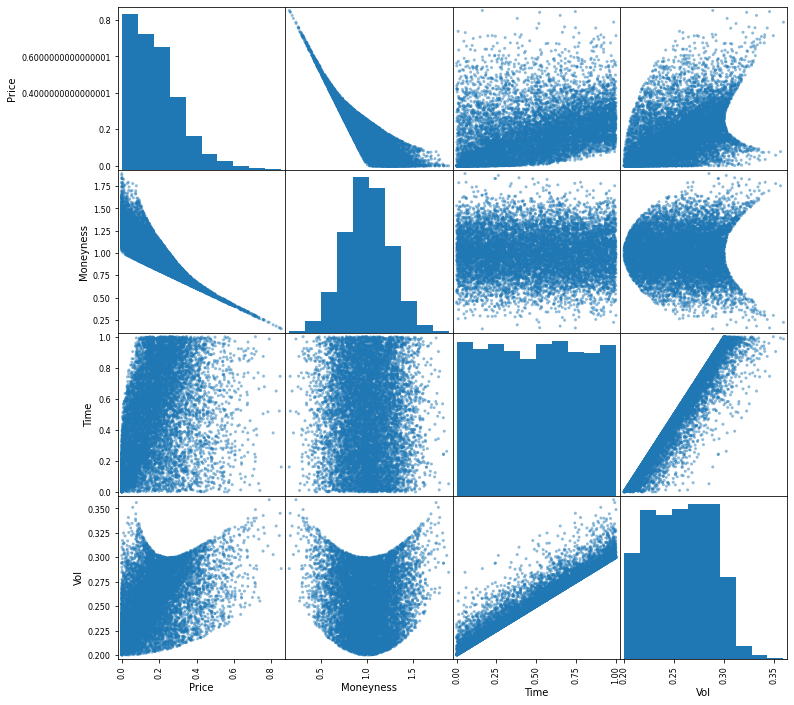

In [13]:
from matplotlib import pyplot
from pandas.plotting import scatter_matrix

pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))
pyplot.show()


The scatterplot reveals very interesting dependencies and relationships between the variables. Let us look at the first row of the chart to see the relationship of price to different variables. We observe that as moneyness decreases (i.e., strike price decreases as compared to the stock price), there is an increase in the price, which is in line with the rationale described in the previous section. Looking at the price versus time to maturity, we see an increase in the option price. The price versus volatility chart also shows an increase in the price with the volatility. However, option price seems to exhibit a nonlinear relationship with most of the variables. This means that we expect our nonlinear models to do a better job than our linear models.
Another interesting relationship is between volatility and strike. The more we deviate from the moneyness of one, the higher the volatility we observe.

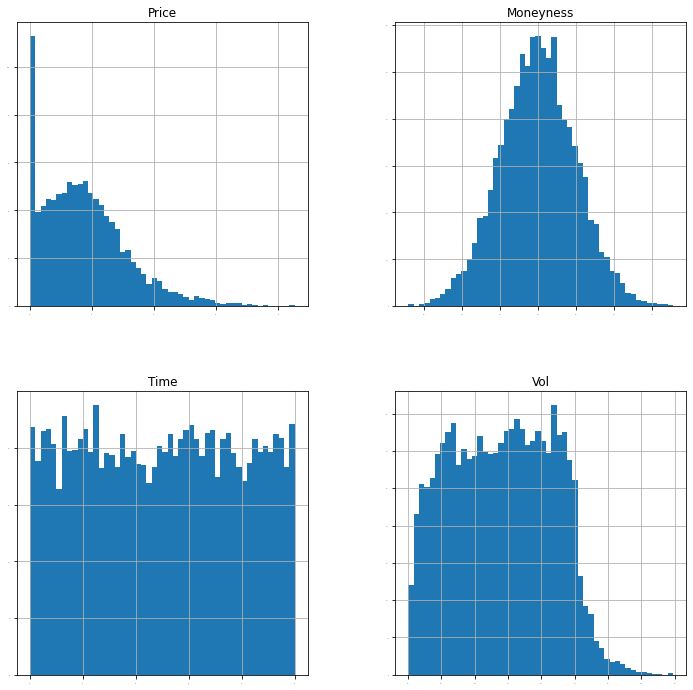

In [56]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

<Axes: title={'center': 'Correlation Matrix'}>

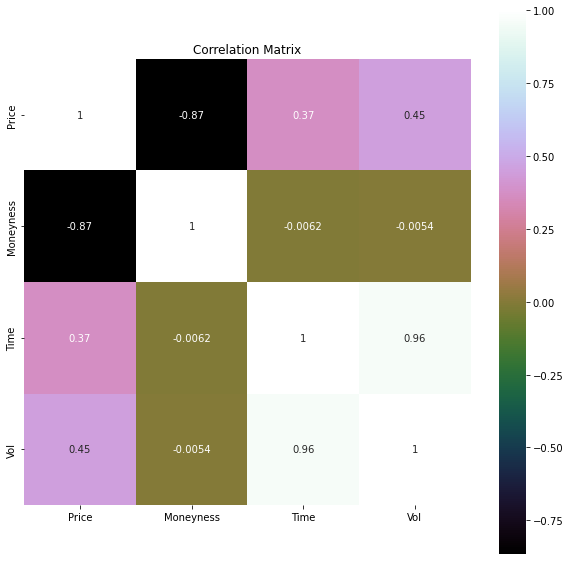

In [60]:
import seaborn as sns
correlation = dataset.corr()
pyplot.figure(figsize=(10,10))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

### Data preparation and feature selection

<Axes: xlabel='Specs'>

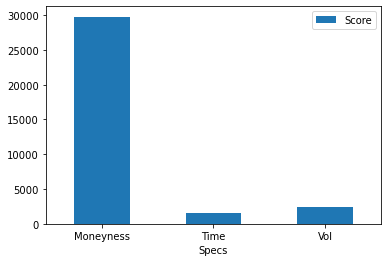

In [25]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
bestfeatures = SelectKBest(k='all', score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(['Moneyness', 'Time', 'Vol'])
#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1) 
featureScores.columns = ['Specs','Score'] 
#naming the dataframe columns 
featureScores.nlargest(10,'Score').set_index('Specs')
import matplotlib.pyplot as plt
featureScores.plot.bar(x = 'Specs', rot=0)

Moneyness is the most important variable for the option price, followed by volatility and time to maturity. But given there are only three predictor variables, we retain all the variables for modeling.

### Evaluate models

In [31]:
validation_size = 0.2
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

# K-fold analysis
num_folds = 10
scoring = 'neg_mean_squared_error'

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
#Linear models and regression trees
models = []
models.append(('LR', LinearRegression()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
#Artificial neural network
models.append(('MLP', MLPRegressor())) 
#Boosting and bagging methods
# Boosting methods
models.append(('ABR', AdaBoostRegressor())) 
models.append(('GBR', GradientBoostingRegressor())) 
# Bagging methods
models.append(('RFR', RandomForestRegressor())) 
models.append(('ETR', ExtraTreesRegressor()))

In [35]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.000352 (0.000022) 0.000352 0.000397
KNN: 0.000016 (0.000007) 0.000008 0.000021
CART: 0.000010 (0.000001) 0.000000 0.000009
SVR: 0.004022 (0.000124) 0.004014 0.004155
MLP: 0.000048 (0.000030) 0.000044 0.000055
ABR: 0.000586 (0.000037) 0.000586 0.000616
GBR: 0.000020 (0.000002) 0.000017 0.000020
RFR: 0.000002 (0.000001) 0.000000 0.000002
ETR: 0.000001 (0.000000) 0.000000 0.000001


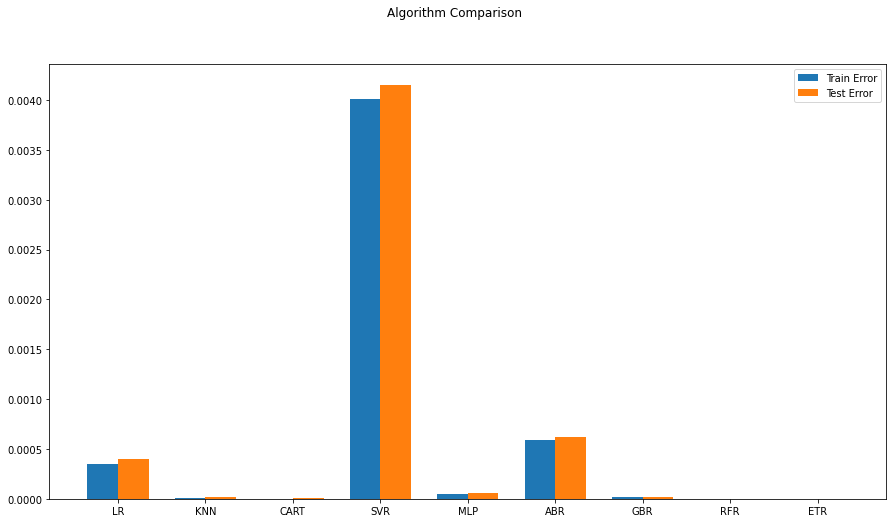

In [43]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

Remove SVR for better visualization

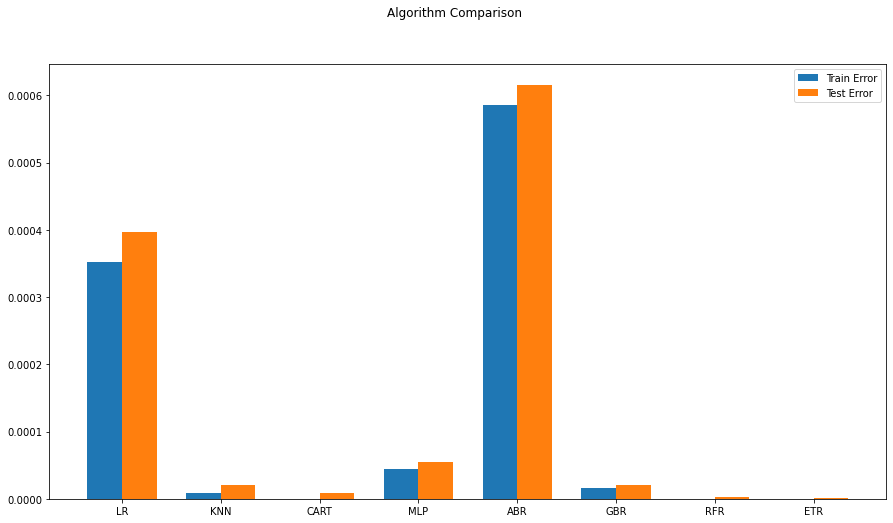

In [42]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names)-1)  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results[0:3] + train_results[4:],  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results[0:3] + test_results[4:], width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names[0:3] + names[4:])
pyplot.show()

We see clearly that the nonlinear models, including classification and regression tree (CART), ensemble models, and artificial neural network perform a lot better that the linear algorithms. Artificial neural networks (ANN) have the natural ability to model any function and can effectively be used in complex derivative pricing situations. Hence we choose ANN for further analysis.

In [54]:
from sklearn.model_selection import GridSearchCV

'''
hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)
    The ith element represents the number of neurons in the ith
    hidden layer.
'''
param_grid={'hidden_layer_sizes': [(20,), (50,), (20,20), (20, 20, 20)]}
model = MLPRegressor()
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.000062 using {'hidden_layer_sizes': (20, 20, 20)}
-0.000360 (0.000337) with: {'hidden_layer_sizes': (20,)}
-0.000063 (0.000040) with: {'hidden_layer_sizes': (50,)}
-0.000157 (0.000177) with: {'hidden_layer_sizes': (20, 20)}
-0.000062 (0.000076) with: {'hidden_layer_sizes': (20, 20, 20)}


In [55]:
# prepare model
model_tuned = MLPRegressor(hidden_layer_sizes=(20, 20, 20))
model_tuned.fit(X_train, Y_train)
# estimate accuracy on validation set
# transform the validation dataset
predictions = model_tuned.predict(X_test)
print(mean_squared_error(Y_test, predictions))

4.5757601272016316e-05
